In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
%matplotlib notebook

In [2]:
vector_data = np.loadtxt("vectorgeom-data10102019.csv", delimiter=',')
ow_data = np.loadtxt("ow-data10102019.csv", delimiter=',')
normal_data = np.loadtxt("normal-data10102019.csv", delimiter=',')
winding_data = np.loadtxt("windingangle-data10102019.csv", delimiter=',')

real_data = np.loadtxt("validation_data/eddies_10102019.csv", delimiter=',')
print(real_data[0:5,:])
#swap lat and long for consistency
real_data.T[[0, 1]] = real_data.T[[1, 0]]
print(real_data[0:5,:])

[[-2.50e+01  3.19e+01  1.55e+05  1.00e+00]
 [-2.90e+01  3.65e+01  5.72e+04  1.00e+00]
 [-2.92e+01  4.97e+01  6.53e+04  1.00e+00]
 [-2.93e+01  4.83e+01  3.16e+04  1.00e+00]
 [-2.50e+01  4.08e+01  9.94e+04  1.00e+00]]
[[ 3.19e+01 -2.50e+01  1.55e+05  1.00e+00]
 [ 3.65e+01 -2.90e+01  5.72e+04  1.00e+00]
 [ 4.97e+01 -2.92e+01  6.53e+04  1.00e+00]
 [ 4.83e+01 -2.93e+01  3.16e+04  1.00e+00]
 [ 4.08e+01 -2.50e+01  9.94e+04  1.00e+00]]


<IPython.core.display.Javascript object>


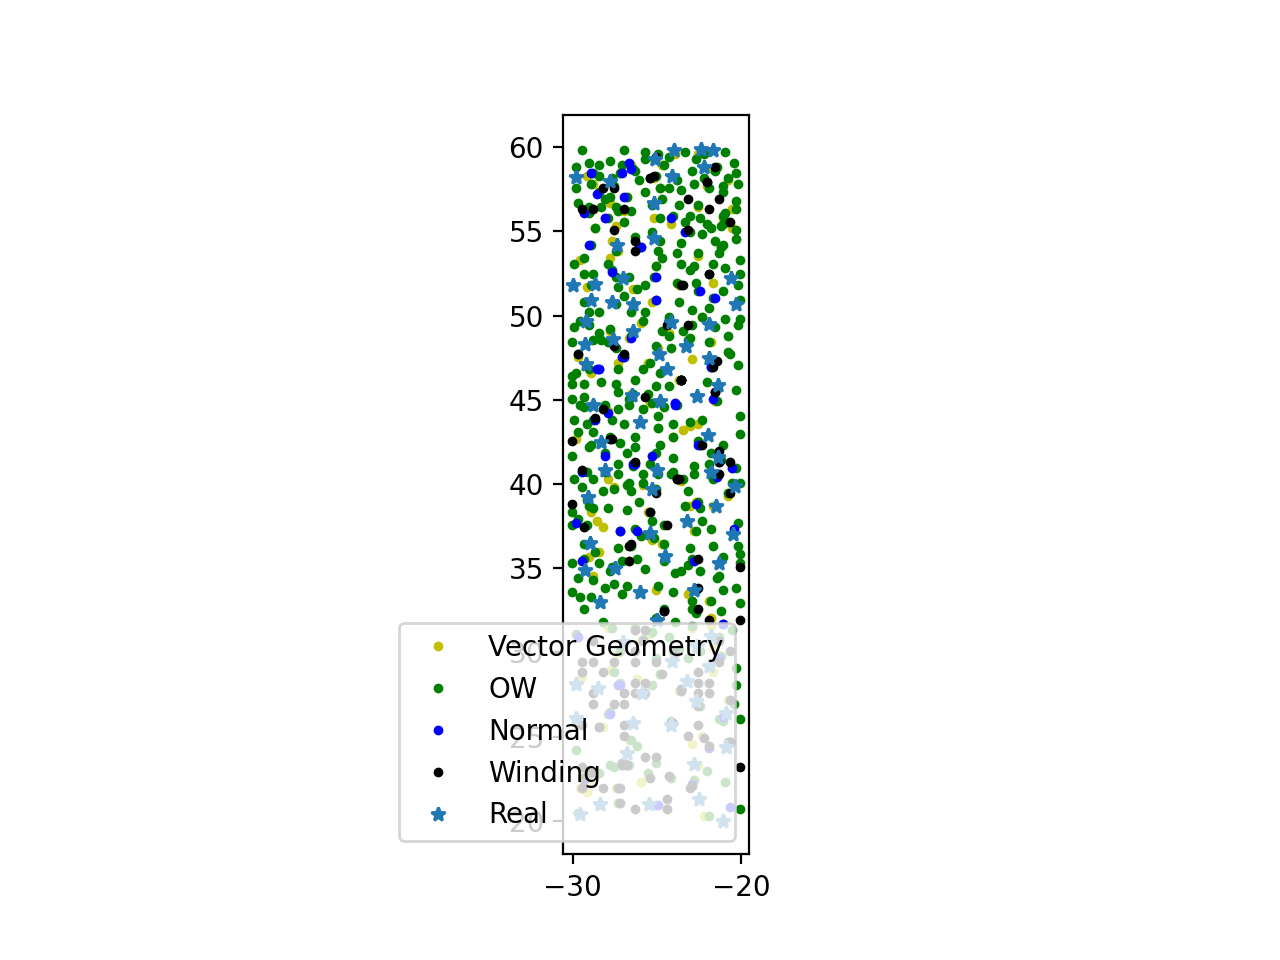

In [3]:
plt.figure(dpi=200)
plt.plot(vector_data[:,1],vector_data[:,0],'y.', markersize=5, label='Vector Geometry')
plt.plot(ow_data[:,1],ow_data[:,0],'g.', markersize=5, label='OW')
plt.plot(normal_data[:,1],normal_data[:,0],'b.', markersize=5, label='Normal')
plt.plot(winding_data[:,1],winding_data[:,0],'k.', markersize=5, label='Winding')
plt.plot(real_data[:,1],real_data[:,0],'*', markersize=5, label='Real')
plt.gca().set_aspect('equal')
plt.legend()

In [4]:
from dataclasses import dataclass

from scipy.spatial import KDTree
from sklearn.metrics.pairwise import haversine_distances

@dataclass
class Method:
    name: str
    points: np.ndarray
    P: int = 0
    TP: int = 0
    FP: int = 0
        
    def compare(self, ground_truth: np.ndarray, dist_tol):
        '''dist_tol is in km'''
        self.P = ground_truth.shape[0]
        
        tree_detected = KDTree(self.points)
        dist, index = tree_detected.query(ground_truth[:,0:2])
        truth = np.deg2rad(ground_truth[:,0:2])
        detected = np.deg2rad(self.points[index,:])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
        
        self.TP = (dist < dist_tol).sum()
        
        tree_truth = KDTree(ground_truth[:,0:2])
        dist, index = tree_truth.query(self.points)
        detected = np.deg2rad(ground_truth[index,0:2])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
        
        self.FP = (dist > dist_tol).sum()
    
    @property
    def TPR(self):
        return self.TP/self.P
    
    @property
    def FDR(self):
        return self.FP/self.P

    
tol = 50 #km THIS IS UP FOR DEBATE!
methods = [Method("OW", ow_data), Method("Winding", winding_data), Method("Vector Geometry", vector_data),
           Method("Normal Method", normal_data)]

for method in methods:
    method.compare(real_data, tol)
    print(f"{method.name=}, {method.TPR=}, {method.FDR=}")

method.name='OW', method.TPR=0.5875, method.FDR=0.9625
method.name='Winding', method.TPR=0.1875, method.FDR=1.0
method.name='Vector Geometry', method.TPR=0.2875, method.FDR=0.9875
method.name='Normal Method', method.TPR=0.075, method.FDR=0.7875
